In [46]:
import zipfile as ZipFile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
train_image = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-image-1591211703.9039922.npy"
train_label = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-label-1591211706.368335-onehot.npy"

In [31]:
train_X = np.load(train_image)
train_y = np.load(train_label)

In [88]:
train_X.shape

(60000, 784)

[0 0 0 0 0 0 0 0 0 0 0 0 1]
12


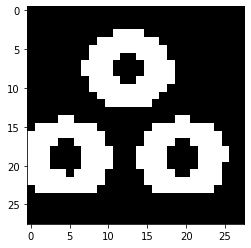

In [257]:
index = 90
plt.imshow(train_X[index].reshape(28,28),cmap="gray")
print(train_y[index])
print(train_y[index].argmax())

In [258]:
class TamilLang(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    x = Image.fromarray(self.X[index].reshape(28,28))
    y = self.y[index].argmax()

    if self.transform != None:
      x = self.transform(x)
    
    return x,y


In [259]:
train_transforms =  transforms.Compose([
        # transforms.Resize((28, 28)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

In [260]:
train_dataset =  TamilLang(train_X,train_y,train_transforms)

In [261]:
train_dataset.transform

Compose(
    ToTensor()
)

In [262]:
train_datasetLoader = DataLoader(train_dataset,batch_size=100,shuffle=True)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1, 28, 28])
torch.Size([])
tensor(9)


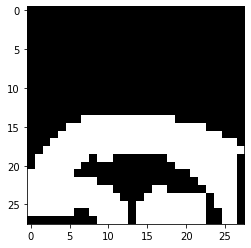

In [263]:
tdl = iter(train_datasetLoader)
tdl = next(tdl)
print(tdl[0].shape) # this is the shape of images along with the batch size (100,1,28,28)
print(tdl[1].shape) # this is the shape of labels along with the batch size (100,13)
print(tdl[0][0].shape) # this is the shape of images alone (1,28,28)
print(tdl[1][0].shape) # this is the shape of label alone
plt.imshow(tdl[0][9].reshape(28,28),cmap="gray") # this is a image
print(tdl[1][9]) # this is the corresponding label

In [360]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,1,0),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,1,0),
     ("MP",2,2,0),
    #  (32,64,3,1,0),
    #  ("MP",2,2,0)
]

In [361]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [362]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [363]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  26 26 16
Max Pooling Layer 2 output dims ::  13 13 16
Conv Layer 3 output dims ::  11 11 32
Max Pooling Layer 4 output dims ::  5 5 32


In [364]:
width * heigth * channels

800

In [375]:
class NeuralNet(nn.Module):

  def __init__(self):
    super(NeuralNet,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
        nn.Linear(800,13),
        # nn.Softmax(dim=1)
    )

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = torch.flatten(x, 1)
    x = self.FC(x)
    return x


In [376]:
model = NeuralNet()

In [377]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=800, out_features=13, bias=True)
  )
)


In [378]:
lr = 0.001
loss_fn = nn.CrossEntropyLoss() # reffer this blog https://neptune.ai/blog/pytorch-loss-functions
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [379]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    if (batch_id + 1) % 100 == 0:
      all_epochs_loss.append(epoch_loss)  
      all_epochs_acc.append(epoch_accuracy) 

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 73.63333324839658, train loss : 73.9215190708638
Epoch : 2, train accuracy : 83.32333307464911, train loss : 42.57316398372256
Epoch : 3, train accuracy : 85.61833321054763, train loss : 35.80932722489045
Epoch : 4, train accuracy : 86.76499999562887, train loss : 32.02233739693962
Epoch : 5, train accuracy : 87.5216665764648, train loss : 29.57407436519861
Epoch : 6, train accuracy : 88.32833326856284, train loss : 27.49261529743673
Epoch : 7, train accuracy : 88.55499991774539, train loss : 26.308188414822013
Epoch : 8, train accuracy : 89.25166680415447, train loss : 24.514348667114973
Epoch : 9, train accuracy : 89.41166679064418, train loss : 23.859023645520207
Epoch : 10, train accuracy : 89.62333349386836, train loss : 22.878332811097295
Epoch : 11, train accuracy : 90.01500015457457, train loss : 22.094538599252694
Epoch : 12, train accuracy : 90.19500028093641, train loss : 21.349239961554623
Epoch : 13, train accuracy : 90.52666687965373, train los

In [381]:
torch.save(model.state_dict(), "TLModel3_30_1.pt")

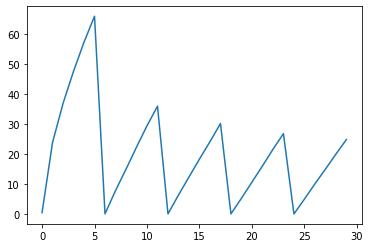

In [383]:
epoch_range = list(range(30))
plt.plot(epoch_range,all_epochs_loss[:30])

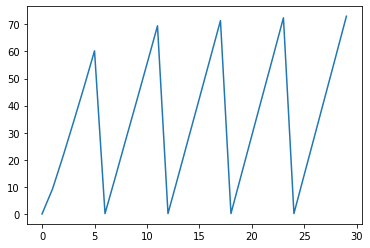

In [384]:
epoch_range = list(range(30))
plt.plot(epoch_range,all_epochs_acc[:30])

In [385]:
model.load_state_dict(torch.load("/content/TLModel3_30_1.pt"))

<All keys matched successfully>

In [386]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=800, out_features=13, bias=True)
  )
)


In [387]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    if (batch_id + 1) % 100 == 0:
      all_epochs_loss.append(epoch_loss)  
      all_epochs_acc.append(epoch_accuracy) 

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 92.41166687011712, train loss : 15.85112873092294
Epoch : 2, train accuracy : 92.47000022729226, train loss : 15.830697074532504
Epoch : 3, train accuracy : 92.4950001935163, train loss : 15.49127171561122
Epoch : 4, train accuracy : 92.5700002610682, train loss : 15.431804093221835
Epoch : 5, train accuracy : 92.62000009417527, train loss : 15.353569683308404
Epoch : 6, train accuracy : 92.60166701674459, train loss : 15.460178448508188
Epoch : 7, train accuracy : 92.82500039537746, train loss : 14.901054753611493
Epoch : 8, train accuracy : 92.70166685183841, train loss : 14.989088301236437
Epoch : 9, train accuracy : 92.78000005086254, train loss : 14.96623357882104
Epoch : 10, train accuracy : 92.81833340724303, train loss : 14.68606447738907
Epoch : 11, train accuracy : 92.83000019192694, train loss : 14.560009553407639
Epoch : 12, train accuracy : 92.93000013629585, train loss : 14.664765789483985
Epoch : 13, train accuracy : 92.93666688601171, train l

In [388]:
torch.save(model.state_dict(), "TLModel3_30_2.pt")

In [389]:
model.eval()

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=800, out_features=13, bias=True)
  )
)

ground truth ::  6
predicted ::  6


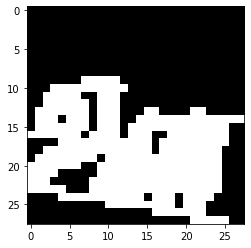

In [412]:
index = 49089

for_testing = train_transforms(train_X[index].reshape(28,28))
plt.imshow(for_testing.reshape(28,28),cmap="gray")
print("ground truth :: ",train_y[index].argmax() + 1)

predict = model(for_testing[None,...])
print("predicted :: ",predict.argmax(dim=1).item() + 1)